<div style="direction:rtl;line-height:300%;">
	<font face="XB Zar" size=5>
		<div align=center>
			<font face="IranNastaliq" size=30>
				<p></p>
				<p></p>
به نام خدا
				<p></p>
			</font>
			<font color=#FF7500>
دانشگاه صنعتی شریف - دانشکده مهندسی کامپیوتر
            </font>
			<p></p>
			<font color=blue>
یادگیری ژرف
            </font>
			<br />
			<br />
پاییز ۱۴۰۰		</div>
		<hr/>
		<div align=center>
		    <font size=6>
			    <br />
تمرین چهارم - Autoencoders - Attention Models
            	<br/>
			</font>
طراح: افشین کریمی
                <br/><br/>
                <br/>
        </style>
	</font>
</div>

<div style="direction:rtl;line-height:300%;">
	<font face="XB Zar" size=5>
		<div align=center>
				<p></p>
				<p></p>
                نام: مهدی کافی
				<br/>
                شماره دانشجویی: ۹۹۲۱۰۷۵۳
        </div>
		<br />
		<hr />
		<style type="text/css" scoped>
        p{
        border: 1px solid #a2a9b1;background-color: #f8f9fa;display: inline-block;
        };
        </style>
	</font>
</div>

# Autoencoders

Just Complete the ToDo Parts 

In [ ]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
  
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
  
# DataLoader is used to load the dataset 
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)

In [ ]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        ''' Todo: Build a linear encoder with Linear
         layer followed by Relu activation function
         784 ==> 9 '''
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(784, 128), 
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 9),
            torch.nn.ReLU(True)
        )
          
        ''' Todo: Build a linear decoder with Linear
         layer followed by Relu activation function
         The Sigmoid activation function
         outputs the value between 0 and 1
         9 ==> 784 '''
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 64),
            torch.nn.ReLU(True),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(True),
            torch.nn.Linear(128, 784),
            torch.nn.Sigmoid()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:

''' Todo: Initialaize model '''
model = AE()
  
''' Todo: Validation using MSE Loss function '''
loss_function = torch.nn.MSELoss()
  
''' Todo: Use an Adam Optimizer with lr = 0.1 '''
# lr of 0.1 was not working well, so I used lr of 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

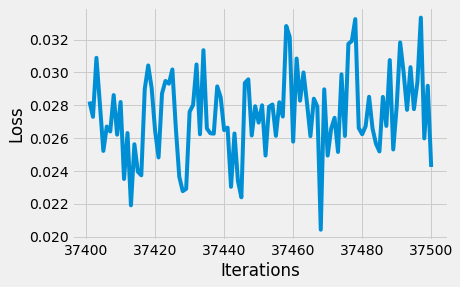

In [ ]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
    for (image, _) in loader:
        
      ''' Todo: Reshaping the image to (-1, 784) '''
      image = image.reshape(-1, 784)
        
      # Output of Autoencoder
      reconstructed = model(image)
        
      ''' Todo: Calculate the loss function '''
      loss = loss_function(reconstructed, image)
        
      # The gradients are set to zero,
      # then the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
        
      # Storing the losses in a list for plotting
      losses.append(loss)
    outputs.append((epochs, image, reconstructed))
  
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
  
''' Todo: Plot the last 100 values '''
losses_len = len(losses)
plt.plot(torch.arange(losses_len-100+1, losses_len+1), losses[-100:])

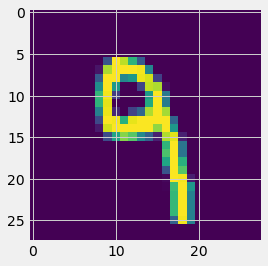

In [ ]:
# Plot the first input image array
for i, item in enumerate(image):
    
  # Reshape the array for plotting
  item = item.reshape(-1, 28, 28)
  plt.imshow(item[0])
  


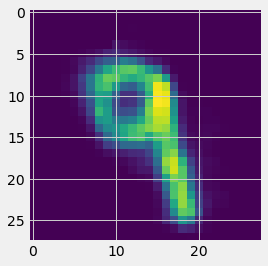

In [ ]:
''' Todo: Plot the first reconstructed input image array '''  
for idx, item in enumerate(reconstructed):
    item = item.reshape(-1, 28, 28)
    plt.imshow(item[0].detach().numpy())

# Attention Models

Just Complete the ToDo Parts 

In [1]:
# Some imports that we require to write the network.
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
# Encoder for the attention network that is similar to the vanilla encoders
class Encoder(nn.Module):
  # Store the parameters
  def __init__(self, input_size, hidden_size, bidirectional = True):
    super(Encoder, self).__init__()
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.bidirectional = bidirectional
    ''' ToDo : Create an LSTM layer '''
    self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, bidirectional=self.bidirectional)
  
  # The Forward function
  def forward(self, inputs, hidden):
#   def forward(self, inputs):
    
    ''' Todo : Pass the input through the LSTM with the provided hidden state '''
    output, hidden = self.lstm(inputs.unsqueeze(0).unsqueeze(0), hidden)
    # output, hidden = self.lstm(inputs)
    return output, hidden
    
  # This function has to be called before passing sentence through the LSTM to initialize the hidden state.  
  def init_hidden(self):
    return (torch.zeros(1 + int(self.bidirectional), 1, self.hidden_size),
        torch.zeros(1 + int(self.bidirectional), 1, self.hidden_size))
    

In [3]:
# This class is the attention based decoder
class AttentionDecoder(nn.Module):
  
  def __init__(self, hidden_size, output_size, vocab_size):
    super(AttentionDecoder, self).__init__()
    self.hidden_size = hidden_size
    self.output_size = output_size
    
    # This layer calculates the importance of the word, by using the previous decoder hidden state and the hidden state of the encoder at that particular time step
    self.attn = nn.Linear(hidden_size + output_size, 1)
    ''' Todo: The 'lstm' layer takes in concatenation of vector obtained by having a weighted sum according to attention weights and the previous word outputted '''
    self.lstm = nn.LSTM(self.hidden_size+vocab_size, self.output_size)
    ''' Todo: Map the output feature space into the size of vocabulary '''
    self.final = nn.Linear(self.output_size, vocab_size)
  
  # The 'init_hidden' function is used in the same way as in the encoder.
  def init_hidden(self):
    return (torch.zeros(1, 1, self.output_size),
      torch.zeros(1, 1, self.output_size))
  
  # The forward function of the decoder
  def forward(self, decoder_hidden, encoder_outputs, input):
    
    # 'weights' list is used to store the attention weights
    weights = []
    for i in range(len(encoder_outputs)):
      print(decoder_hidden[0][0].shape)
      print(encoder_outputs[0].shape)
      # Pass each encoder output through the 'attn' layer along with 
      # decoder's previous hidden state by concatenating them and store 
      # them in the 'weights' list 
      weights.append(self.attn(torch.cat((decoder_hidden[0][0], 
                                          encoder_outputs[i]), dim = 1)))
    # print(f"lennnnnn{len(weights)}")
      
    ''' Todo : scale weights in range (0,1) by applying softmax activation '''
    normalized_weights = F.softmax(torch.tensor(weights)).unsqueeze(0)
    # print(normalized_weights)
    # To calculate the weighted sum, we use batch matrix multiplication
    # print("#"*30)
    # print(normalized_weights.unsqueeze(0).unsqueeze(0).size())
    # print(encoder_outputs.view(1, -1, self.hidden_size).size())
    attn_applied = torch.bmm(normalized_weights.unsqueeze(0),
                             encoder_outputs.view(1, -1, self.hidden_size))
    # print(f"attn_applied: {attn_applied.size()}")
    # print(input.size())
    input_lstm = torch.cat((attn_applied[0], input[0]), dim = 1) #if we are using embedding, use embedding of input here instead
    # print(input_lstm.size())
    output, hidden = self.lstm(input_lstm.unsqueeze(0), decoder_hidden)
    
    output = self.final(output[0])
    
    return output, hidden, normalized_weights

In [4]:
# Testing the code
bidirectional = True
c = Encoder(10, 20, bidirectional)
a, b = c.forward(torch.randn(10), c.init_hidden())
print(f"a: {a.shape}")
print(f"b0: {b[0].shape}")
print(f"b1: {b[1].shape}")

x = AttentionDecoder(20 * (1 + bidirectional), 25, 30)
# print("#"*30)
# print(f"cata: {torch.cat((a, a)).size()}")
y, z, w = x.forward(x.init_hidden(), torch.cat((a,a)), torch.zeros(1,1, 30)) 
print(y.shape)
print(z[0].shape)
print(z[1].shape)
print(w)

a: torch.Size([1, 1, 40])
b0: torch.Size([2, 1, 20])
b1: torch.Size([2, 1, 20])
torch.Size([1, 25])
torch.Size([1, 40])
torch.Size([1, 25])
torch.Size([1, 40])
torch.Size([1, 30])
torch.Size([1, 1, 25])
torch.Size([1, 1, 25])
tensor([[0.5000, 0.5000]])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
